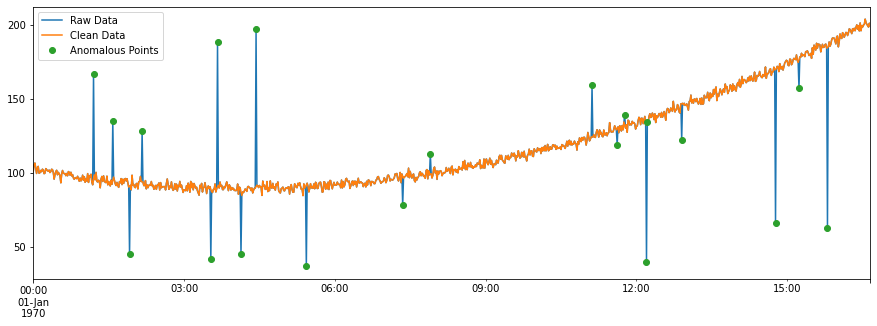

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng(12345)

# Define index
nx = 1000
index = pd.date_range(start="1970", periods=nx, freq="1T")

# Define signal and noise
x = np.linspace(0, 10, nx)
signal =  2*x**2- 10* x + 2
noise = np.random.normal(loc=100, size=nx, scale=2)
y = noise + signal

# Add anomalies
anom_num = rng.integers(low=0, high=200, size=20)
anom_ids = rng.integers(low=0, high=nx, size=20)
y[anom_ids] = anom_num
is_anom = [item in anom_ids for item in range(nx)]

# Pandas DataFrame and plot
raw_data = pd.Series(y, index = index)
clean_data = raw_data[np.invert(is_anom)]
raw_data.plot(figsize=(15,5))
clean_data.plot()
raw_data[anom_ids].plot(style='o')
plt.legend(['Raw Data', 'Clean Data','Anomalous Points'])
plt.savefig('Toy_data_set.png', bbox_inches='tight', dpi=1000)
#plt.autoscale()
plt.rcParams.update({'font.size': 22})


In [3]:
raw_data.to_csv('raw_data.csv')

In [4]:
# Transform variables to lists
x = (np.array(raw_data.index, dtype=np.int64) - raw_data.index[0].value) / 1e9
y = raw_data.to_numpy()

# Create a polynomial fit and apply the fit to data
poly_order = 3
coefs = np.polyfit(x, y, poly_order)
y_pred = np.polyval(coefs, x)

In [5]:
# Calculate hat matrix
X_mat = np.vstack((np.ones_like(x), x)).T
X_hat = X_mat @ np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T
hat_diagonal = X_hat.diagonal()

In [6]:
from scipy.stats import t as student_dist

# Calculate degrees of freedom
n = len(y)
dof = n - 3  # Using p = 2 from paper

# Calculate standardised residuals 
res = y - y_pred
sse = np.sum(res ** 2)
t_res = res * np.sqrt(dof / (sse * (1 - hat_diagonal) - res**2))

0.6789066622077469


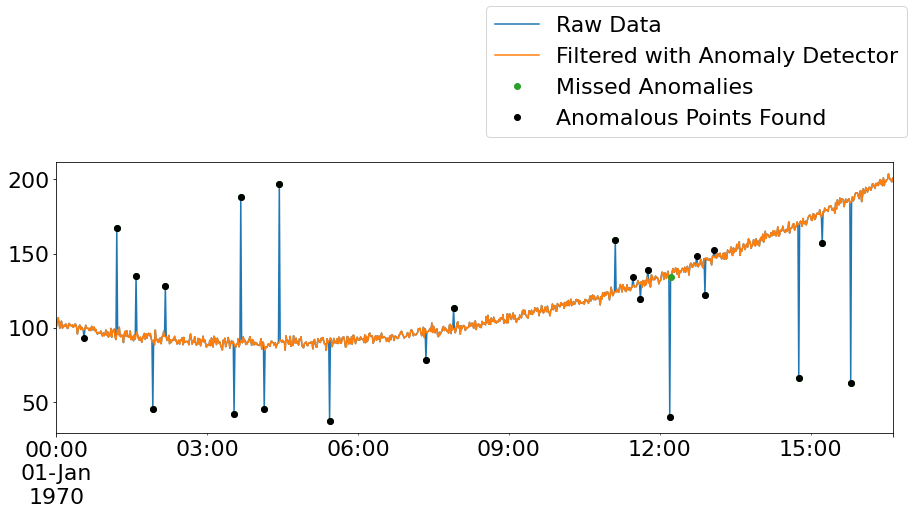

In [7]:
# Return filtered dataframe with the anomalies removed using BC value
alpha=0.05
bc_relaxation = 1/6
#bc_relaxation = 0.3
bc = student_dist.ppf(1 - alpha/(2*n) , df=dof) * bc_relaxation
print(bc)
mask = np.logical_and(t_res < bc, t_res > - bc)

# Plot anomalous and filtered data
ax=raw_data.plot(figsize=(15,5))

raw_data[mask].plot(ax=ax)
raw_data[anom_ids].plot(style='o')

raw_data[np.invert(mask)].plot(style='ok')
plt.legend(['Raw Data','Filtered with Anomaly Detector', 'Missed Anomalies', 'Anomalous Points Found'],bbox_to_anchor=(0.5, 1.05))
plt.rcParams.update({'font.size': 22})
plt.savefig('results_1.png', bbox_inches='tight', dpi=1000)


4.439995243580404


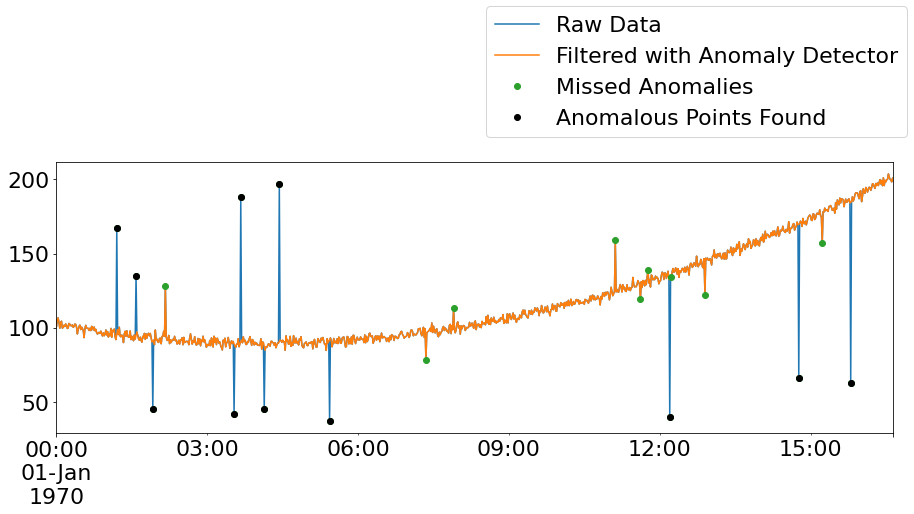

In [19]:
# Return filtered dataframe with the anomalies removed using BC value
alpha=0.01
bc_relaxation = 1
#bc_relaxation = 0.3
bc = student_dist.ppf(1 - alpha/(2*n) , df=dof) * bc_relaxation
print(bc)
mask = np.logical_and(t_res < bc, t_res > - bc)

# Plot anomalous and filtered data
ax=raw_data.plot(figsize=(15,5))

raw_data[mask].plot(ax=ax)
raw_data[anom_ids].plot(style='o')

raw_data[np.invert(mask)].plot(style='ok')
plt.legend(['Raw Data','Filtered with Anomaly Detector', 'Missed Anomalies', 'Anomalous Points Found'],bbox_to_anchor=(0.5, 1.05))
plt.rcParams.update({'font.size': 22})
#plt.savefig('results_1.png', bbox_inches='tight', dpi=1000)


In [20]:
len(raw_data[np.invert(mask)])

11

In [9]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

def check_anomaly(pred_mask, real_mask):
    print(recall_score(real_mask, pred_mask))
    print(precision_score(real_mask, pred_mask))
    print(confusion_matrix(real_mask, pred_mask))
    


In [10]:
check_anomaly(np.invert(mask),is_anom)

0.95
0.8260869565217391
[[976   4]
 [  1  19]]


In [36]:
4/23

0.17391304347826086

In [41]:
def anomaly_detector(raw_data, bc_relaxation = 1/6, poly_order=1):
    
    # Transform variables to lists
    x = (np.array(raw_data.index, dtype=np.int64) - raw_data.index[0].value) / 1e9
    y = raw_data.to_numpy()

    # Create a polynomial fit and apply the fit to data
    coefs = np.polyfit(x, y, poly_order)
    y_pred = np.polyval(coefs, x)
    
    # Calculate hat matrix
    X_mat = np.vstack((np.ones_like(x), x)).T
    X_hat = X_mat @ np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T
    hat_diagonal = X_hat.diagonal()

    # Calculate degrees of freedom
    n = len(y)
    dof = n - 3  # Using p = 2 from paper

    # Calculate standardised residuals 
    res = y - y_pred
    sse = np.sum(res ** 2)
    t_res = res * np.sqrt(dof / (sse * (1 - hat_diagonal) - res**2))
    
    # Return filtered dataframe with the anomalies removed using BC value
    alpha=0.05
    bc = student_dist.ppf(1 - alpha / (2 * n), df=dof) * bc_relaxation
    mask = np.logical_and(t_res < bc, t_res > - bc)
    
    return mask


/tmp/ipykernel_113933/157715891.py:7: UserWarning: Authenticated towards inferred project 'publicdata'. Pass project to the CogniteClient constructor or set the environment variable 'COGNITE_PROJECT' to suppress this warning.
  client = CogniteClient(api_key=api_key, client_name='public-data-user')


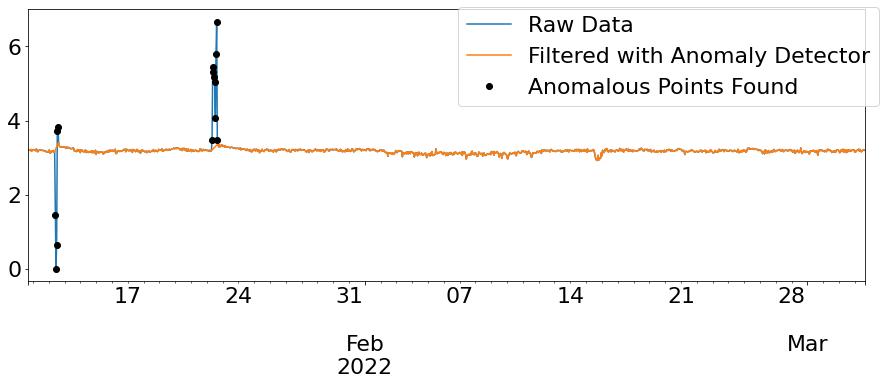

In [45]:
from cognite.client import CogniteClient
import os
import pandas as pd

# Instantiate CogniteClient
api_key = os.environ['PUBLIC_DATA_API_KEY']
client = CogniteClient(api_key=api_key, client_name='public-data-user')

# Retrieve Data from Cognite API
df = client.datapoints.retrieve(external_id='pi:160696', start='60d-ago', end='now', granularity='1h', aggregates=['average']).to_pandas()
df = df['pi:160696|average']

# Apply anomaly detection and plot
mask = anomaly_detector(df, bc_relaxation=0.3)
df.plot(figsize=(15,5))
df[mask].plot()
df[np.invert(mask)].plot(style='ok')
plt.legend(['Raw Data','Filtered with Anomaly Detector', 'Anomalous Points Found'],bbox_to_anchor=(0.5, 1.05))
plt.savefig('results_2.png', bbox_inches='tight', dpi=1000)